In [2]:
from pathlib import Path
from typing import Union, Dict
import matplotlib.pyplot as plt
import pandas as pd
import re
from typing import Dict

In [3]:
def load_dataset(dataset_path: Union[str, Path]):
    if not isinstance(dataset_path, str) and not isinstance(dataset_path, Path):
        raise TypeError("dataset_path must be a Path object or string.")
    
    p = dataset_path if isinstance(dataset_path, Path) else Path(dataset_path)
    if not p.exists():
        raise FileNotFoundError(f"The dataset was not found at: {str(p)}")
    
    filename = p.name
    path = p.absolute().resolve()
    
    if filename.endswith((".parquet.gzip", ".parquet")):
        try:
            return pd.read_parquet(path, engine="fastparquet")
        except:
            return pd.read_parquet(path)
    elif filename.endswith(".json"):
        return pd.read_json(path)
    elif filename.endswith(".pkl"):
        return pd.read_pickle(path)
    raise ValueError(f"The provided dataset format is not taken in charge. Use json, parquet or pickle. Found: {filename}")

def load_dataset_and_preprocess(dataset_path: str):
    df = load_dataset(dataset_path)
    df_timeout = df.loc[df['execution'] == 'timeout']
    df_empty = df.drop(df_timeout.index).loc[df['execution'].str.startswith("[]")]
    df_fail = df.drop(df_timeout.index).drop(df_empty.index).loc[df['execution'].str.startswith('exception')]
    df_no_errors = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)
    
    return {
        "base": df,
        "timeout": df_timeout,
        "empty": df_empty,
        "fail": df_fail,
        "no_errors": df_no_errors
    }

In [4]:
path_to_original_executed_dataset = "../datasets/fq18_2/final_queries_1.1_modified_executed_no_limits.parquet.gzip"
# path_to_original_executed_dataset = "../outputs/final_queries_v1.1_full_execution_limit_10.parquet.gzip"
original_dataset = load_dataset_and_preprocess(path_to_original_executed_dataset)

In [5]:
path_to_final_executed_dataset = "../datasets/fq18_2/final_fq18_with_limit_10/generated_prompt-executed.parquet.gzip"
# path_to_final_executed_dataset = "../outputs/dataset_pipeline/final_fq18_with_limit_10/generated_prompt-executed.parquet.gzip"
final_dataset = load_dataset_and_preprocess(path_to_final_executed_dataset)

path_to_final_executed_dataset_no_limit = "../datasets/fq18_2/final_fq18_without_limit/generated_prompt-executed.parquet.gzip"
# path_to_final_executed_dataset_no_limit = "../outputs/dataset_pipeline/final_fq18_without_limit/generated_prompt-executed.parquet.gzip"
final_dataset_no_limit = load_dataset_and_preprocess(path_to_final_executed_dataset_no_limit)

Original dataset:
Number of timed out requests: 133
Number of failed requests: 122
Number of empty responses: 109
Number of successful responses: 2415

Final dataset (with limit 10):
Number of timed out requests: 126
Number of failed requests: 46
Number of empty responses: 112
Number of successful responses: 2487

Final dataset (no limit):
Number of timed out requests: 126
Number of failed requests: 49
Number of empty responses: 111
Number of successful responses: 2485



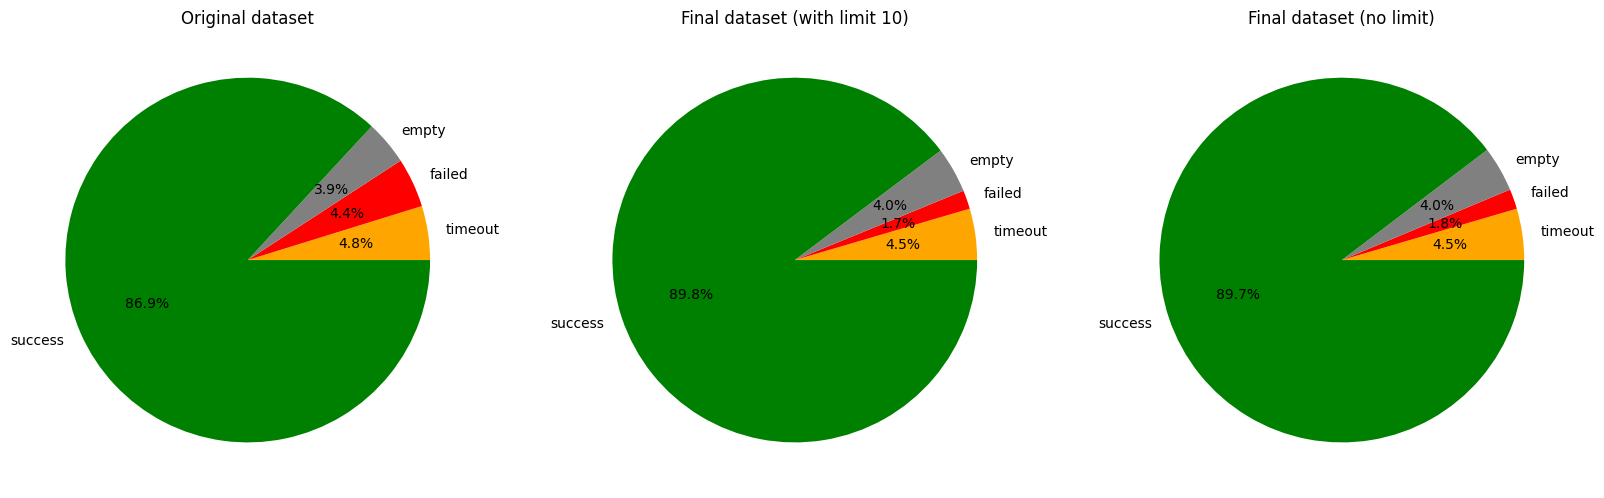

In [6]:
def analyze_queries_status_proportion(datasets, ax):
    print(f"Number of timed out requests: {len(datasets['timeout'])}")
    print(f"Number of failed requests: {len(datasets['fail'])}")
    print(f"Number of empty responses: {len(datasets['empty'])}")
    print(f"Number of successful responses: {len(datasets['no_errors'])}")

    labels = ["timeout", "failed", "empty", "success"]
    sizes  = [
        len(datasets['timeout']),
        len(datasets['fail']),
        len(datasets['empty']),
        len(datasets['no_errors'])
    ]

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])
    
# Call the function with your dataframes as arguments
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 20)
print("Original dataset:")
analyze_queries_status_proportion(original_dataset, ax1)
ax1.set_title(label="Original dataset")
print()
print("Final dataset (with limit 10):")
analyze_queries_status_proportion(final_dataset, ax2)
ax2.set_title(label="Final dataset (with limit 10)")
print()
print("Final dataset (no limit):")
analyze_queries_status_proportion(final_dataset_no_limit, ax3)
ax3.set_title(label="Final dataset (no limit)")
print()

Original dataset:
Number of timed out requests: 133
Number of failed requests: 122
Number of empty responses: 109
Number of successful responses: 2415

Final dataset (with limit 10):
Number of timed out requests: 126
Number of failed requests: 46
Number of empty responses: 112
Number of successful responses: 2487

Final dataset (no limit):
Number of timed out requests: 126
Number of failed requests: 49
Number of empty responses: 111
Number of successful responses: 2485



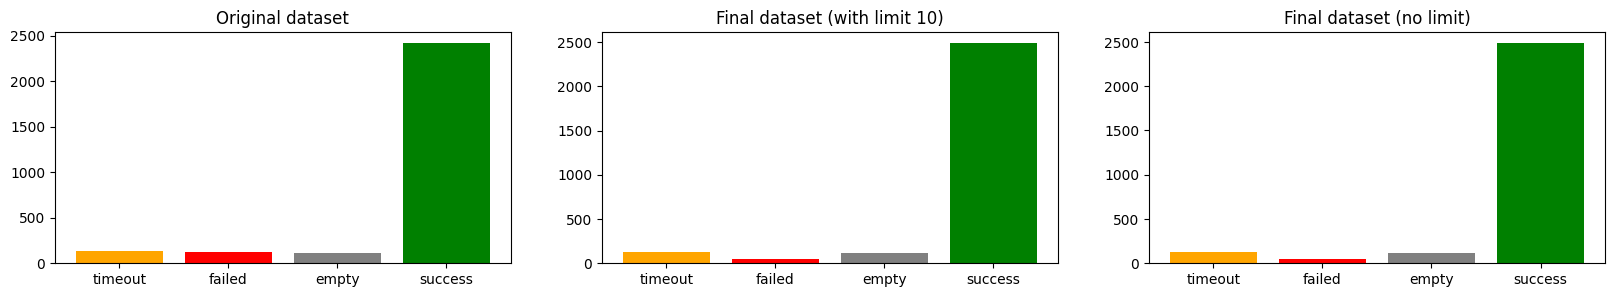

In [7]:
def analyze_queries_status_proportion(datasets, ax):
    print(f"Number of timed out requests: {len(datasets['timeout'])}")
    print(f"Number of failed requests: {len(datasets['fail'])}")
    print(f"Number of empty responses: {len(datasets['empty'])}")
    print(f"Number of successful responses: {len(datasets['no_errors'])}")

    labels = ["timeout", "failed", "empty", "success"]
    sizes  = [
        len(datasets['timeout']),
        len(datasets['fail']),
        len(datasets['empty']),
        len(datasets['no_errors'])
    ]

    ax = ax.bar(labels, sizes, color=["orange", "red", "grey", "green"])
    
# Call the function with your dataframes as arguments
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 3)
print("Original dataset:")
analyze_queries_status_proportion(original_dataset, ax1)
ax1.set_title(label="Original dataset")
print()
print("Final dataset (with limit 10):")
analyze_queries_status_proportion(final_dataset, ax2)
ax2.set_title(label="Final dataset (with limit 10)")
print()
print("Final dataset (no limit):")
analyze_queries_status_proportion(final_dataset_no_limit, ax3)
ax3.set_title(label="Final dataset (no limit)")
print()

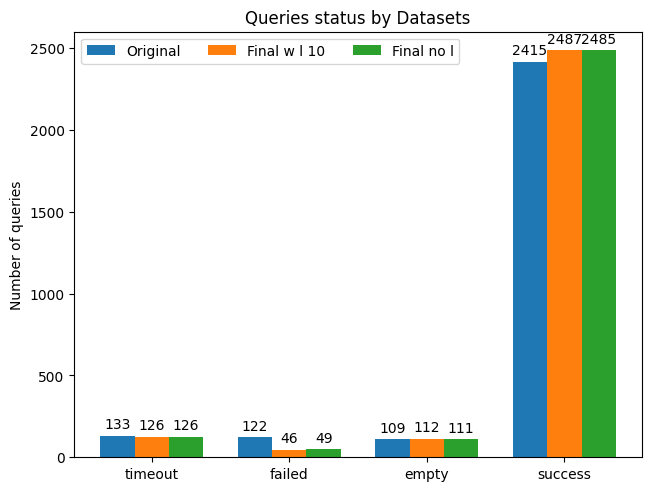

In [8]:
def grouped_barcharts(ax, labels, data, width=0.25):
    x = list(range(len(labels)))  # the label locations
    multiplier = 0

    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar([y + offset for y in x], measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    
    ax.set_xticks([y + width for y in x], labels)
    ax.legend(loc='upper left', ncols=3)

labels = ("timeout", "failed", "empty", "success")
data = {
    'Original': (len(original_dataset["timeout"]), len(original_dataset["fail"]), len(original_dataset["empty"]), len(original_dataset["no_errors"])),
    'Final w l 10': (len(final_dataset["timeout"]), len(final_dataset["fail"]), len(final_dataset["empty"]), len(final_dataset["no_errors"])),
    'Final no l': (len(final_dataset_no_limit["timeout"]), len(final_dataset_no_limit["fail"]), len(final_dataset_no_limit["empty"]), len(final_dataset_no_limit["no_errors"])),
}

fig, ax = plt.subplots(layout='constrained')
# fig, ax = plt.subplots(figsize=(7, 5))
    
grouped_barcharts(ax, labels, data, 0.25)

ax.set_ylabel('Number of queries')
ax.set_title('Queries status by Datasets')
ax.set_ylim(0, 2600);


In [9]:
def find_error_type(x: str):
    if not isinstance(x, str):
        return None
    
    http_error = re.compile(r"exception: ([0-9]+)")
    module_request_error = re.compile(r"exception: module 'requests.exceptions'")
    server_timeout_error = re.compile(r"java.util.concurrent.TimeoutException")
    empty_error = re.compile(r"exception: query is empty")
    
    http_error_match = http_error.search(x[:20])
    
    if http_error_match != None:
        return http_error_match.group(1)
    
    if module_request_error.search(x[:50]):
        return "requests"
    
    if server_timeout_error.search(x[len(x)-10000:]):
        return "server timeout"
    
    if empty_error.search(x[:100]):
        return "empty query"
    
    return None

def analyse_errors(datasets: Dict):
    datasets['fail']['error_type'] = datasets['fail'].apply(lambda x: find_error_type(x['execution']), axis=1)

    distinct_errors = datasets['fail'].error_type.unique()

    print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
    for err in distinct_errors:
        if err == None:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'].isnull()])}")
        else:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'] == err])}")

    for err in distinct_errors:
        if err == None:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'].isnull()].iloc[0]['execution'][:256]}")
        else:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'] == err].iloc[0]['execution'][:256]}")

In [10]:
# CAUTION! If there is a link provided in the example, it may be truncated. Therefore leading to another error message !!
# It is truncated for presentation purposes.
print("Original dataset:")
analyse_errors(original_dataset)
print()

print("Final dataset (with limit 10):")
analyse_errors(final_dataset)
print()

print("Final dataset (no limit):")
analyse_errors(final_dataset_no_limit)
print()

Original dataset:
There is 2 types of errors: 500, 400
Number of 500: 45
Number of 400: 77
Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of 400: exception: 400 Client Error: Bad Request for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+schema%3A+%3Chttp%3A%2F%2Fschema.org%2F%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+wdt%3A+%3Chttp%3A

Final dataset (with limit 10):
There is 2 types of errors: 500, 400
Number of 500: 42
Number of 400: 4
Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APR

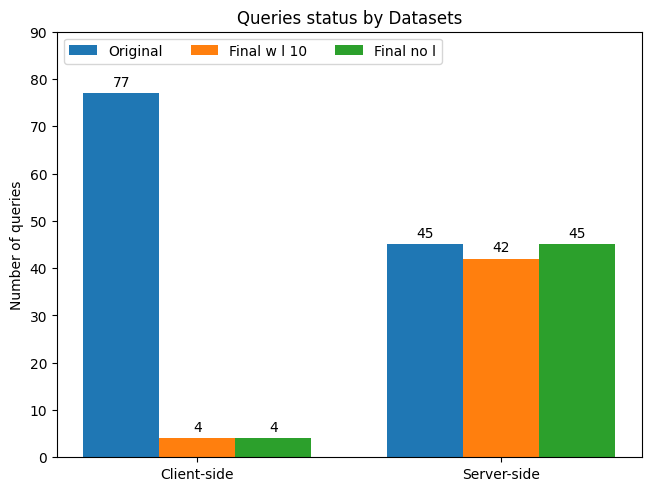

In [11]:
tmp_ori = original_dataset['fail']['error_type'].value_counts().to_dict()
tmp_f10 = final_dataset['fail']['error_type'].value_counts().to_dict()
tmp_fin = final_dataset_no_limit['fail']['error_type'].value_counts().to_dict()

labels = ("Client-side", "Server-side")
data = {
    'Original': (tmp_ori['400'], tmp_ori['500']),
    'Final w l 10': (tmp_f10['400'], tmp_f10['500']),
    'Final no l': (tmp_fin['400'], tmp_fin['500']),
}

fig, ax = plt.subplots(layout='constrained')
# fig, ax = plt.subplots(figsize=(7, 5))
    
grouped_barcharts(ax, labels, data, 0.25)

ax.set_ylabel('Number of queries')
ax.set_title('Queries status by Datasets')
ax.set_ylim(0, 90);

Original dataset:
error_type
400    77
500    45
Name: count, dtype: int64

Final dataset (with limit 10):
error_type
500    42
400     4
Name: count, dtype: int64

Final dataset (no limit):
error_type
500    45
400     4
Name: count, dtype: int64


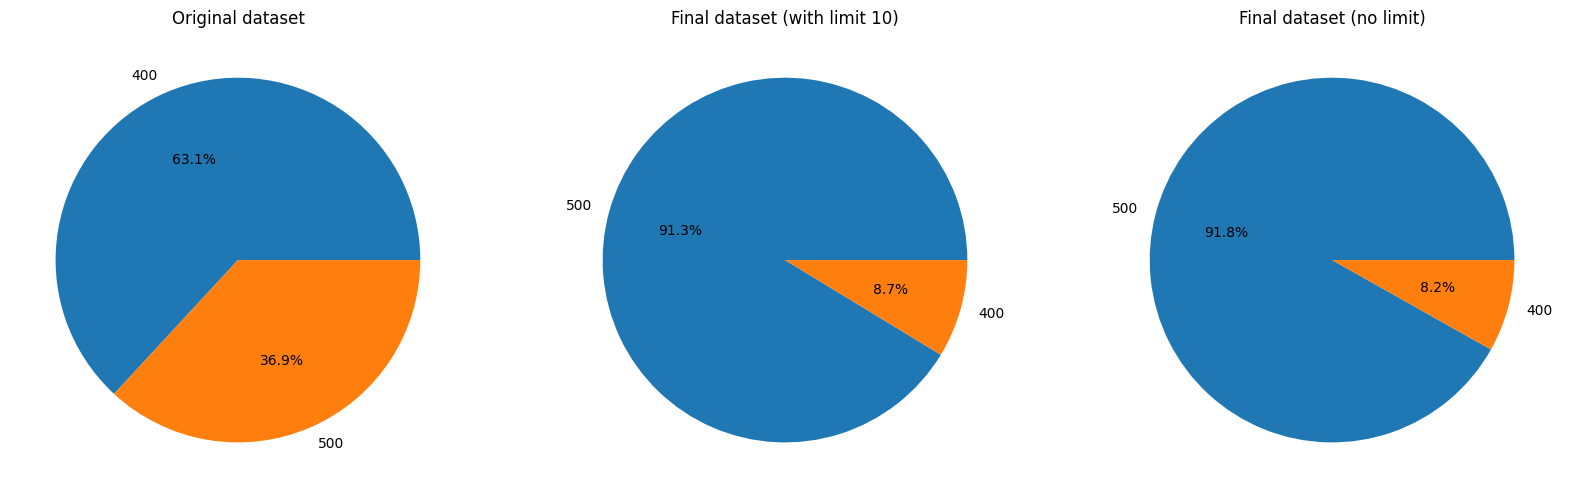

In [12]:
def plot_error_types(datasets: Dict, ax):
    value_counts = datasets['fail']['error_type'].value_counts()
    print(value_counts)

    labels = list(datasets['fail']['error_type'].value_counts().index)
    sizes = list(value_counts)
    
    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%');

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 20)

print("Original dataset:")
plot_error_types(original_dataset, ax1)
ax1.set_title(label="Original dataset")
print()

print("Final dataset (with limit 10):")
plot_error_types(final_dataset, ax2)
ax2.set_title(label="Final dataset (with limit 10)")
print()

print("Final dataset (no limit):")
plot_error_types(final_dataset_no_limit, ax3)
ax3.set_title(label="Final dataset (no limit)");

In [13]:
def generate_index_of_errors(all_errors: pd.Series):
    error_types = sorted(list(all_errors.value_counts().index))
    return {x[0]: i for i, x in enumerate(error_types)}

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    pattern_multiple_same_prefixes = re.compile(r"Multiple prefix declarations for prefix")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
    if pattern_multiple_same_prefixes.search(last_error):
        errors.append("Prefix duplicates")
        
    return errors

def classify_500_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_stackoverflow = re.compile(r"StackOverflowError")
    pattern_geo_input_no_resolve_point = re.compile(r"Input could not be resolved as point")
    pattern_estimated_time_too_long = re.compile(r"The estimated execution time")
    pattern_out_of_memory = re.compile(r"MemoryManagerOutOfMemory")
    pattern_nullpointerexception = re.compile(r"java.lang.NullPointerException")
    pattern_invalid_json_error = re.compile(r"exception: 500 Server Error: the response has an Invalid chunk length")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1] if len(reduced_stack) > 0 else ""
    
    errors = []
    if pattern_stackoverflow.search(last_error):
        errors.append("stack overflow")
    if pattern_geo_input_no_resolve_point.search(last_error):
        errors.append("GeoSpatialSearchException: input could not be resolved as point")
    if pattern_estimated_time_too_long.search(last_error):
        errors.append("estimated time to execute too long")
    if pattern_out_of_memory.search(last_error):
        errors.append("Out of memory")
    if pattern_nullpointerexception.search(last_error):
        errors.append("NullPointerException")
    if pattern_invalid_json_error.search(stack_trace):
        errors.append("Invalid JSON")
        
    return errors

def classify_requests_errors(execution_result):
    pattern = re.compile(r"exception: module 'requests.exceptions' has no attribute 'JSONDecodeError'")
    errors = []
    
    if pattern.search(execution_result[:100]):
        errors.append("no attribute 'JSONDecodeError'")
    
    return errors


def classify_all_errors(execution_result: str):
    if not isinstance(execution_result, str) or execution_result == None:
        return None
    
    error = find_error_type(execution_result)
    
    
    if error == None:
        return None
    elif error == "400":
        return classify_400_errors(execution_result)
    elif error == "500":
        return classify_500_errors(execution_result)
    elif error == "requests":
        return classify_requests_errors(execution_result)
    elif error == "server timeout":
        return ["server timeout"]
    elif error == "empty query":
        return ['empty query']
    
    
    raise NotImplementedError(f"This function is not implemented for errors other than 400, 500, requests, invalid JSON, server timeout, found: {error}")

ERROR_INDEX = {
    "undefined prefix": 0,
    "parse exception due to limit": 1,
    "parse exception": 2,
    "lexical error": 3,
    "non-aggregate variable in select expression": 4,
    "Prefix duplicates": 5,
    "stack overflow": 6,
    "GeoSpatialSearchException: input could not be resolved as point": 7,
    "estimated time to execute too long": 8,
    "Out of memory": 9,
    "no attribute 'JSONDecodeError'": 10,
    "Invalid JSON": 11,
    "server timeout": 12,
    "NullPointerException": 13,
    "empty query": 14
}

original_dataset['fail']['error_classified'] = original_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
original_dataset['fail']['ierror_classified'] = original_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset['fail']['error_classified'] = final_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset['fail']['ierror_classified'] = final_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset_no_limit['fail']['error_classified'] = final_dataset_no_limit['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset_no_limit['fail']['ierror_classified'] = final_dataset_no_limit['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

Original dataset:
error_classified
[lexical error]                                  33
[undefined prefix]                               27
[parse exception]                                16
[non-aggregate variable in select expression]     1
Name: count, dtype: int64

Final dataset (with limit 10):
error_classified
[parse exception]                 3
[parse exception due to limit]    1
Name: count, dtype: int64

Final dataset (no limit):
error_classified
[parse exception]    4
Name: count, dtype: int64


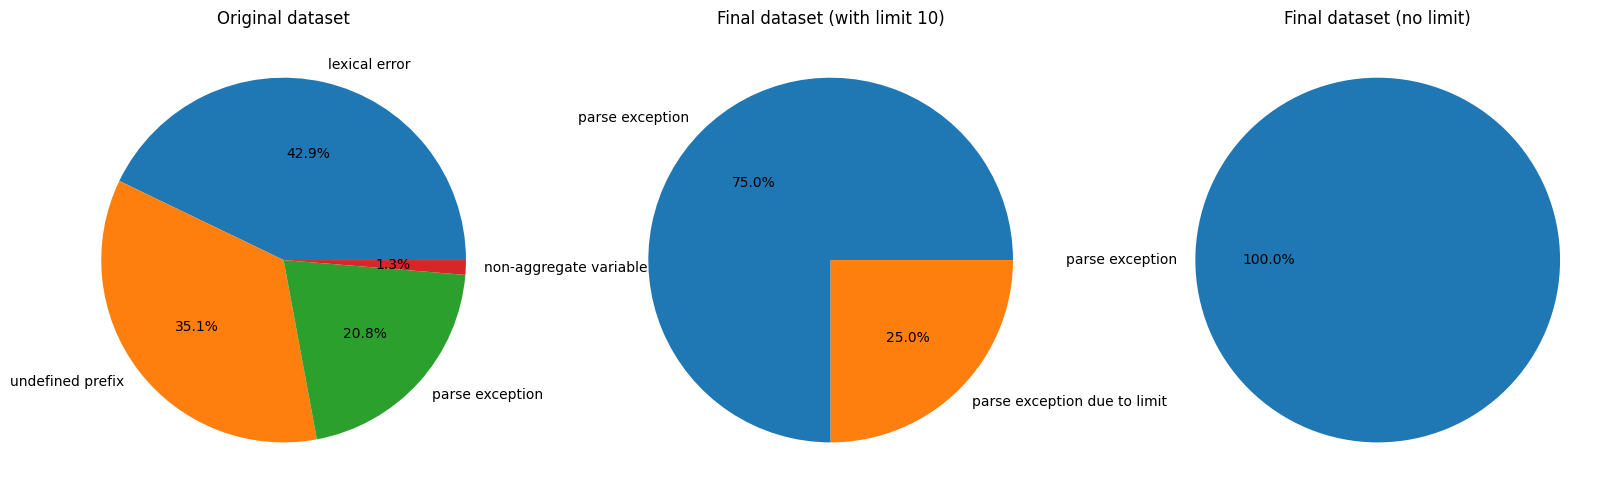

In [14]:
def plot_error_400(datasets, ax):
    df_error400 = datasets['fail'].loc[datasets['fail']['error_type'] == '400']

    value_counts = df_error400.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error400.error_classified.value_counts().index)))
    sizes = list(value_counts)

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

print("Original dataset:")
plot_error_400(original_dataset, ax1)
ax1.set_title(label="Original dataset")
print()

print("Final dataset (with limit 10):")
plot_error_400(final_dataset, ax2)
ax2.set_title(label="Final dataset (with limit 10)")
print()

print("Final dataset (no limit):")
plot_error_400(final_dataset_no_limit, ax3)
ax3.set_title(label="Final dataset (no limit)");

Original dataset:
error_classified
[stack overflow]                                                     33
[GeoSpatialSearchException: input could not be resolved as point]     7
[Invalid JSON]                                                        3
[Out of memory]                                                       2
Name: count, dtype: int64

Final dataset (with limit 10):
error_classified
[stack overflow]                                                     34
[GeoSpatialSearchException: input could not be resolved as point]     7
[Out of memory]                                                       1
Name: count, dtype: int64

Final dataset (no limit):
error_classified
[stack overflow]                                                     34
[GeoSpatialSearchException: input could not be resolved as point]     7
[Out of memory]                                                       3
[Invalid JSON]                                                        1
Name: count, dtype: int64


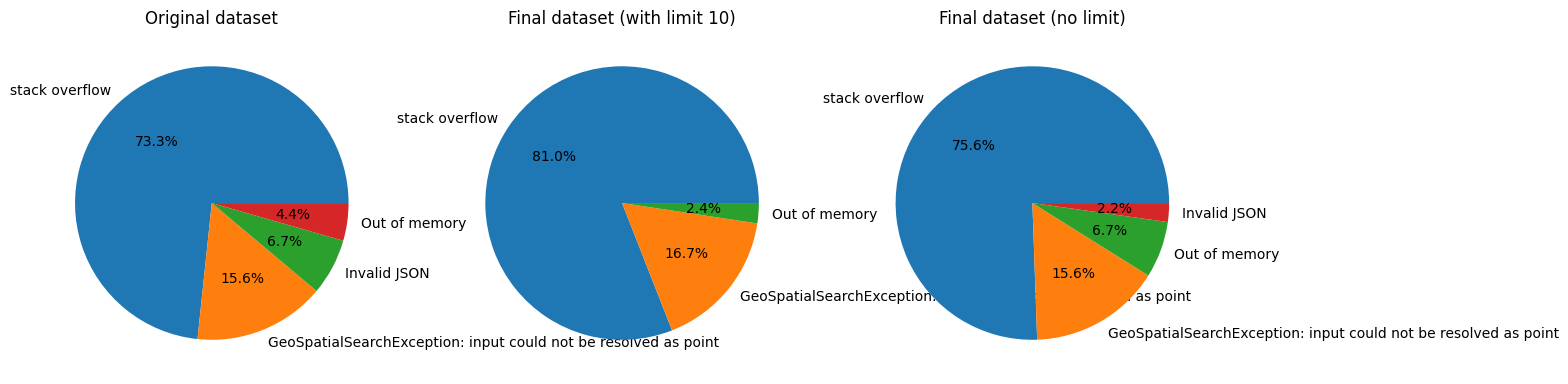

In [15]:
def plot_error_500(datasets, ax):
    df_error500 = datasets['fail'].loc[datasets['fail']['error_type'] == '500']

    value_counts = df_error500.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error500.error_classified.value_counts().index)))
    sizes = list(value_counts)

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 20))
print("Original dataset:")
plot_error_500(original_dataset, ax1)
ax1.set_title(label="Original dataset")
print()

print("Final dataset (with limit 10):")
plot_error_500(final_dataset, ax2)
ax2.set_title(label="Final dataset (with limit 10)")
print()

print("Final dataset (no limit):")
plot_error_500(final_dataset_no_limit, ax3)
ax3.set_title(label="Final dataset (no limit)");